## Bus Arrival Time Prediction and Real Time Updating 
##### Group 27

##### Running time Prediction Model with Points of interest data


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/bus-arrival-time-prediction/bus_running_time_all_features.csv


In [2]:
# import libraries

import xgboost as xgb
from sklearn import metrics
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import shap
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


In [3]:
# read the dataset - running times
running_time_data = pd.read_csv('/kaggle/input/bus-arrival-time-prediction/bus_running_time_all_features.csv')

In [4]:
running_time_data.head()

,Unnamed: 0.1,Unnamed: 0,trip_id,deviceid,direction,segment,date,start_time,end_time,run_time,...,place_of_worship,place_of_education,hospital,tourist_attractions,commercial_places,public_places,nearby_bus_stops,fuel_station,total_poi_count,average_poi_distance
0,0,0,1.0,262.0,1.0,1.0,2021-10-01,06:39:49,06:40:58,0 days 00:01:09,...,10,2,0,48,3,13,4,1,16,0.002356
1,1,1,1.0,262.0,1.0,2.0,2021-10-01,06:42:12,06:45:42,0 days 00:03:30,...,8,13,2,35,1,11,1,0,19,0.006437
2,2,2,1.0,262.0,1.0,3.0,2021-10-01,06:45:42,06:53:58,0 days 00:08:16,...,9,11,2,15,0,2,0,1,13,0.003714
3,3,3,1.0,262.0,1.0,4.0,2021-10-01,06:54:04,06:57:19,0 days 00:03:15,...,6,3,0,5,0,2,0,1,7,0.007617
4,4,4,1.0,262.0,1.0,5.0,2021-10-01,06:57:19,06:58:56,0 days 00:01:37,...,4,1,0,1,0,3,0,1,6,0.003597


In [5]:
running_time_data.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'trip_id', 'deviceid', 'direction',
       'segment', 'date', 'start_time', 'end_time', 'run_time',
       'run_time_in_seconds', 'length', 'day_of_week', 'time_of_day',
       'Sunday/holiday', 'saturday', 'weekday/end', 'week_no', 'rt(w-1)',
       'rt(w-2)', 'rt(w-3)', 'rt(t-1)', 'rt(t-2)', 'rt(n-1)', 'rt(n-2)',
       'rt(n-3)', 'hour_of_day', 'day', 'month', 'temp', 'precip', 'windspeed',
       'conditions', 'dt(n-1)', 'max_elevation', 'avg_elevation',
       'segment_gradient_average', 'stop_to_stop_gradient',
       'significant_bend_count', 'place_of_worship', 'place_of_education',
       'hospital', 'tourist_attractions', 'commercial_places', 'public_places',
       'nearby_bus_stops', 'fuel_station', 'total_poi_count',
       'average_poi_distance'],
      dtype='object')

In [6]:
features = ['deviceid','week_no','day_of_week','time_of_day','Sunday/holiday','saturday','segment','length','precip','temp',
            'rt(n-1)','rt(n-2)', 'rt(n-3)','rt(t-1)', 'rt(t-2)', 'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'dt(n-1)','max_elevation','avg_elevation',
'total_poi_count', 'average_poi_distance','segment_gradient_average', 'stop_to_stop_gradient','significant_bend_count','run_time_in_seconds']
run_time_dataset = running_time_data[features]

In [7]:
run_time_dataset.head()

,deviceid,week_no,day_of_week,time_of_day,Sunday/holiday,saturday,segment,length,precip,temp,...,rt(w-3),dt(n-1),max_elevation,avg_elevation,total_poi_count,average_poi_distance,segment_gradient_average,stop_to_stop_gradient,significant_bend_count,run_time_in_seconds
0,262.0,1.0,4.0,6.50,0.0,0,1.0,0.6261,0.0,20.0,...,96.0,0.0,532.0,511.650000,16,0.002356,0.004662,0.079618,2.0,69.0
1,262.0,1.0,4.0,6.50,0.0,0,2.0,1.2808,0.0,20.0,...,247.0,74.0,532.0,529.500000,19,0.006437,0.015948,-0.007985,7.0,210.0
2,262.0,1.0,4.0,6.75,0.0,0,3.0,2.1125,0.0,20.0,...,506.0,0.0,544.0,529.100000,13,0.003714,-0.011355,-0.004628,11.0,496.0
3,262.0,1.0,4.0,6.75,0.0,0,4.0,1.5513,0.0,20.0,...,192.0,6.0,527.0,515.714286,7,0.007617,0.008623,-0.010950,4.0,195.0
4,262.0,1.0,4.0,6.75,0.0,0,5.0,0.8450,0.0,20.0,...,114.0,0.0,488.0,480.333333,6,0.003597,-0.040850,-0.050612,2.0,97.0


In [8]:
print ("No of data points in the dataset : %d \nNo of Features\t: %d"%(run_time_dataset.shape[0],(run_time_dataset.shape[1]-1)))

No of data points in the dataset : 200679 
No of Features	: 26


In [9]:
# Splitting the dataset for training and testing
# In this case we are considering first 36 weeks for training and remaining weeks for testing
X_train_run_time = run_time_dataset[run_time_dataset["week_no"]<=36]
X_test_run_time = run_time_dataset[run_time_dataset["week_no"]>36]
X_test_run_time.reset_index(drop=True,inplace=True)

In [10]:
print ("No of data points in the training set : %d \nNo of data points in the test set : %d"%(X_train_run_time.shape[0],X_test_run_time.shape[0]))

No of data points in the training set : 169329 
No of data points in the test set : 31350


In [11]:
# remove week no
X_train_run_time = X_train_run_time.drop("week_no",axis = 1)
X_test_run_time = X_test_run_time.drop("week_no",axis = 1)


<Axes: >

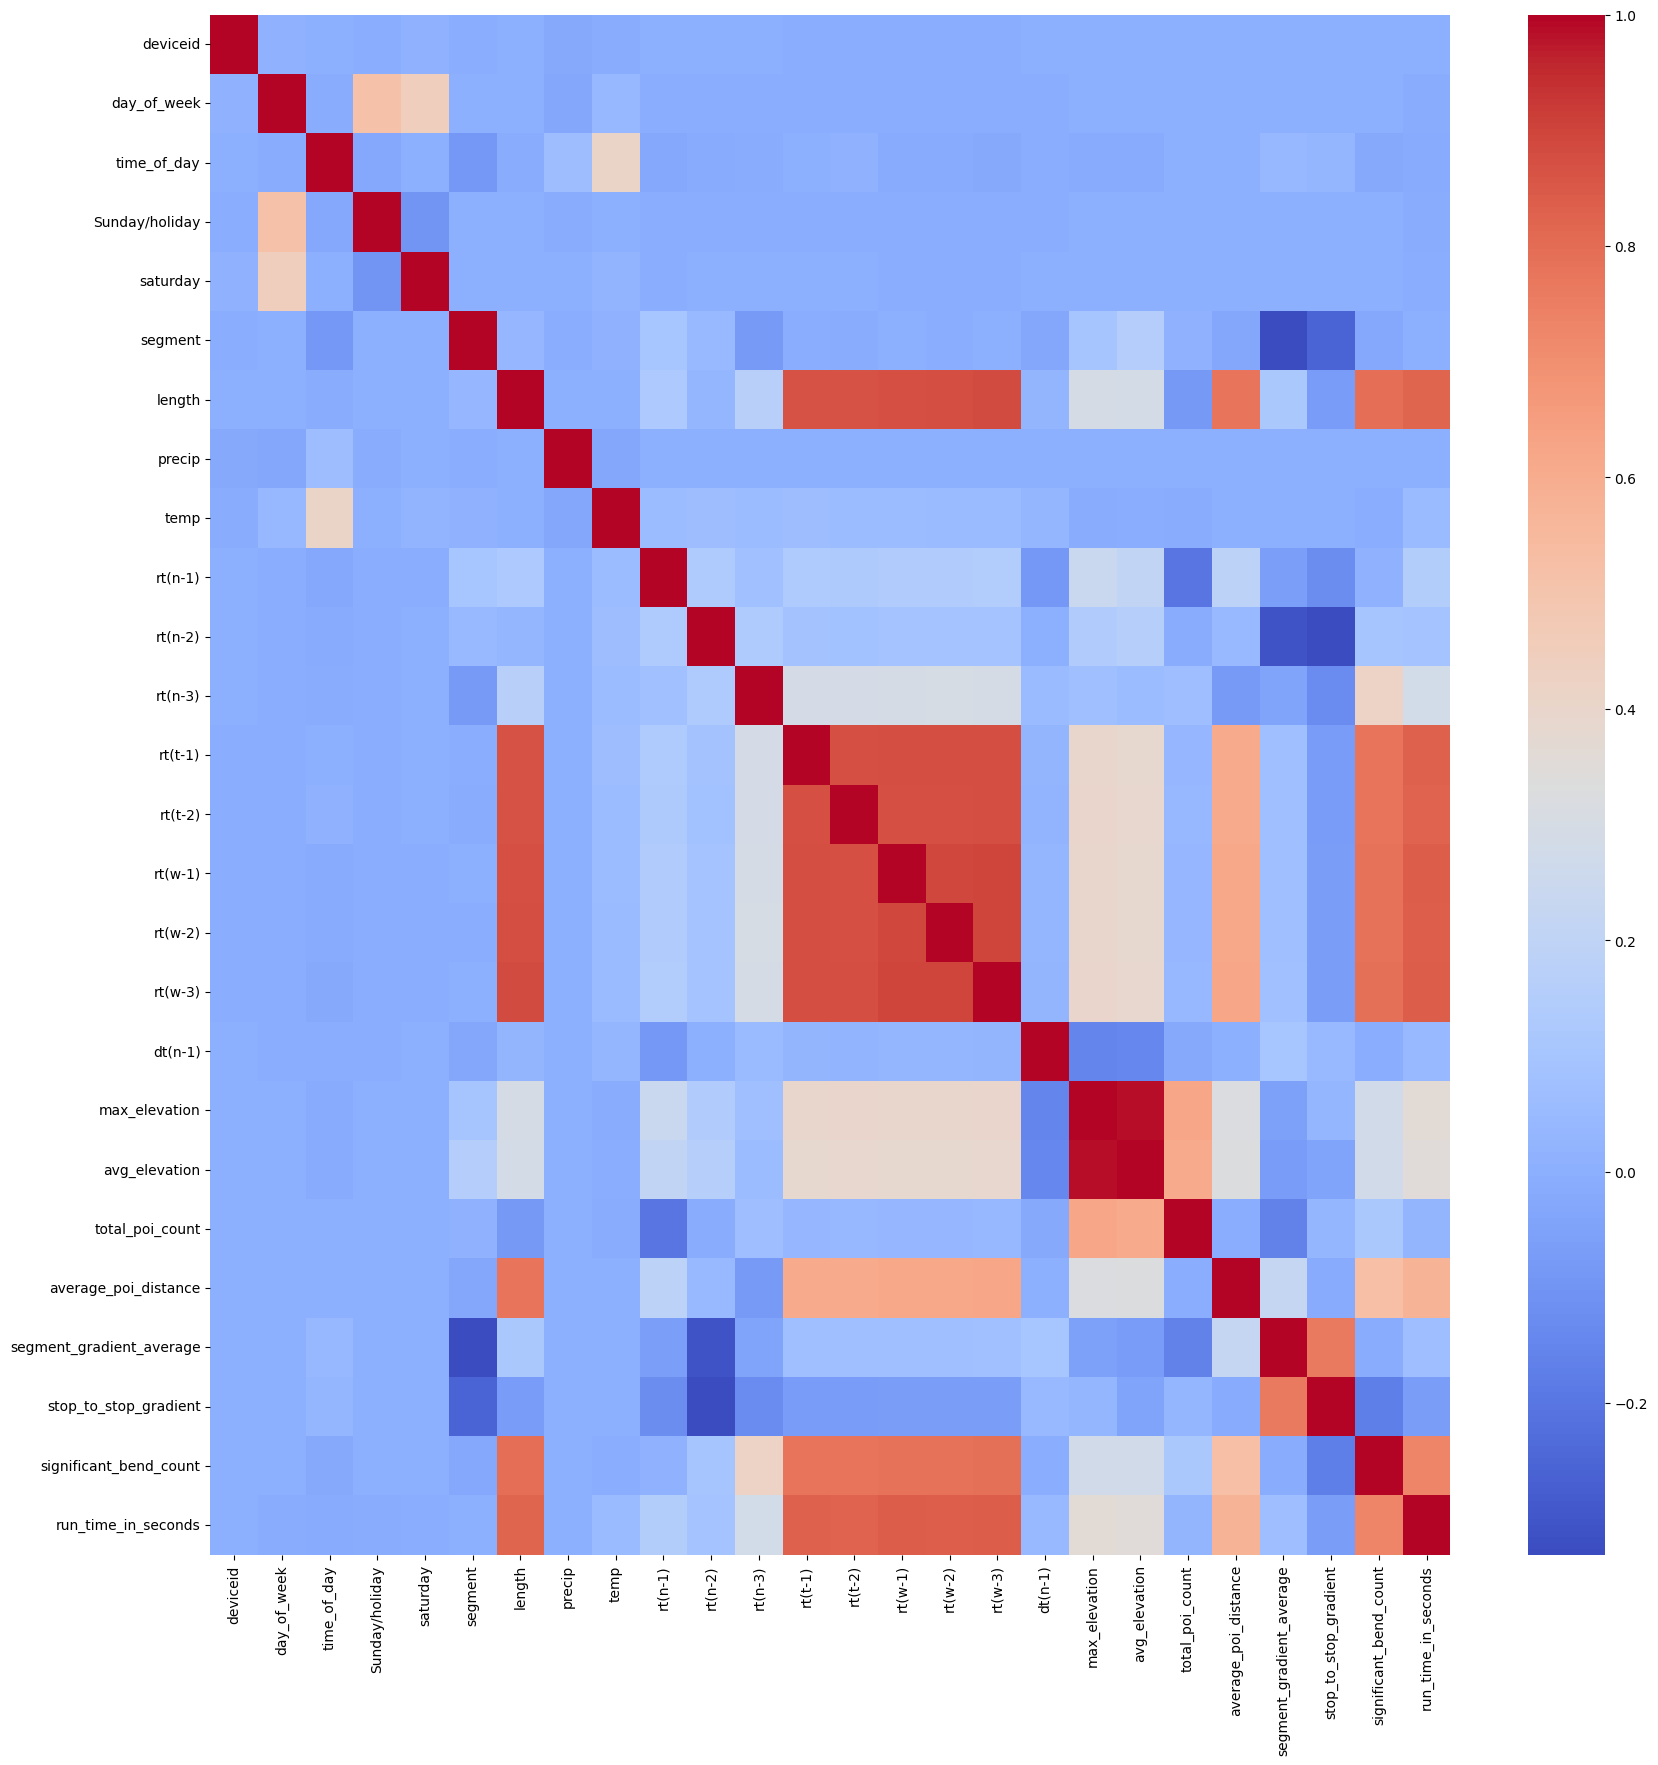

In [12]:
plt.figure(figsize=[20,20])
correlation  = X_train_run_time.corr()
sns.heatmap(data=correlation, cmap = 'coolwarm')

In [13]:
# Get X and Y of train and test
y_train_run_time = X_train_run_time.pop('run_time_in_seconds')
y_test_run_time = X_test_run_time.pop('run_time_in_seconds')

In [14]:
#Scaling
scaler = StandardScaler()
scaler.fit(X_train_run_time)
X_train_scaled = scaler.transform(X_train_run_time)
X_test_scaled = scaler.transform(X_test_run_time)

In [15]:
#PCA
pca  = PCA(n_components = 16)
pca.fit(X_train_scaled)
X_train_pca = pca.transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [16]:
#Hyperparmeter Grid
parameters = {
    "max_depth": [4, 6, 5, 10],
    "learning_rate": [0.01, 0.05, 0.1,0.3],
    "n_estimators": [ 200, 500,600],
    'reg_alpha':[0.001, 0.005, 0.01, 0.05],
    "colsample_bytree": [0.3, 0.6,0.8],
    "random_state":[123],
    "eval_metric":['mape']
    
}

In [17]:
cv_split = TimeSeriesSplit(n_splits=6,max_train_size = 2000, test_size=100)
model = xgb.XGBRegressor()
grid_search_cv = GridSearchCV(estimator=model, cv=cv_split, param_grid=parameters)
grid_search_cv.fit(X_train_pca, y_train_run_time)

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=2000, n_splits=6, test_size=100),
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, impo...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid={'colsample_bytree': [0.3, 0.6, 0.8],
                         'eval_metric': ['mape'],
                         'learning_rate': [0.01, 0.05, 0.1, 0.3],
                         'max_depth': [4, 6, 5, 10],
                         'n_estimators': [200, 500, 600], 'random_state': [123],
                         'reg_alpha': [0.001, 0.005, 0.01, 0.05]})

In [18]:
run_time_model = grid_search_cv.best_estimator_
run_time_model.fit(X_train_pca,y_train_run_time)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, early_stopping_rounds=None,
             enable_categorical=False, eval_metric='mape', feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=500, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=123, ...)

In [19]:
predictions = run_time_model.predict(X_test_pca)

In [20]:
predictions

array([102.62173 , 241.32732 , 401.89877 , ..., 204.51157 , 184.94502 ,
        84.736275], dtype=float32)

#### Model Evaluation

In [21]:
mse = metrics.mean_squared_error(y_test_run_time,predictions)
rmse = np.sqrt(mse)
mae = metrics.mean_absolute_error(y_test_run_time,predictions)
mape = metrics.mean_absolute_percentage_error(y_test_run_time,predictions)
r2 = metrics.r2_score(y_test_run_time,predictions)

In [22]:
print ("Model Evaluation\n")
print ("Mean Squared Error\t: %f\nRoot Mean Squared Error\t: %f\nMean Absolute Error\t: %f\nMean Absolute Percentage Error\t: %f\nR-Squared\t: %f"%(mse,rmse,mae,mape,r2))

Model Evaluation

Mean Squared Error	: 3264.710898
Root Mean Squared Error	: 57.137649
Mean Absolute Error	: 36.642192
Mean Absolute Percentage Error	: 0.220645
R-Squared	: 0.763764


In [23]:
run_time_model.save_model('run_time_model_v2.json')


### Feature Importance Analysis 

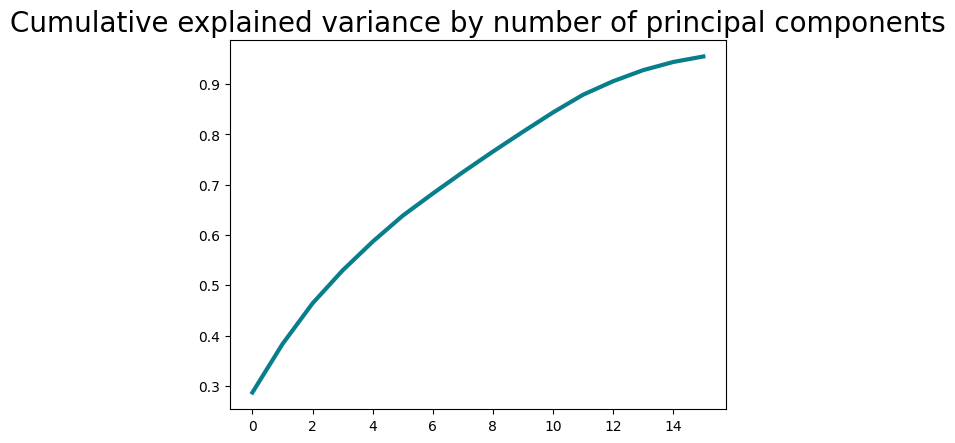

In [24]:
plt.plot(pca.explained_variance_ratio_.cumsum(), lw=3, color='#087E8B')
plt.title('Cumulative explained variance by number of principal components', size=20)
plt.show()

In [25]:
input_features = ['deviceid','day_of_week','time_of_day','Sunday/holiday','saturday','segment','length','precip','temp',
            'rt(n-1)','rt(n-2)', 'rt(n-3)','rt(t-1)', 'rt(t-2)', 'rt(w-1)', 'rt(w-2)', 'rt(w-3)', 'dt(n-1)','max_elevation','avg_elevation',
'total_poi_count', 'average_poi_distance','segment_gradient_average', 'stop_to_stop_gradient','significant_bend_count']
loadings = pca.components_.T * np.sqrt(pca.explained_variance_)
loading_matrix = pd.DataFrame(loadings, index=input_features)
loading_matrix

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15
deviceid,-0.005254,-0.006191,-0.003466,0.018134,0.015890,0.009257,0.186083,-0.006724,-0.559731,0.803464,0.036619,-0.060197,0.019114,0.020006,0.001494,-0.000267
day_of_week,-0.005913,0.003216,-0.006607,0.934755,0.017324,0.004726,0.019236,0.016642,0.031490,0.005924,0.011945,0.000794,-0.007588,-0.015708,0.004698,0.005352
time_of_day,-0.014468,-0.083337,-0.051678,-0.001361,-0.810720,-0.105521,-0.035659,-0.178508,0.065879,0.099028,-0.096800,0.068679,-0.169622,-0.478708,0.041021,0.021737
Sunday/holiday,-0.005611,0.004361,-0.005359,0.664726,0.085863,0.017805,-0.675409,-0.023090,-0.016666,0.116093,0.030944,-0.005598,-0.006016,-0.015056,0.002862,-0.001593
saturday,-0.004117,0.000820,-0.004497,0.555980,-0.036667,-0.008769,0.776012,0.054205,0.097586,-0.100894,-0.007608,0.008157,-0.004682,-0.012823,0.002882,-0.001989
segment,0.017379,0.403911,0.254861,0.008349,0.144948,-0.281630,0.027778,-0.419752,-0.026845,-0.079151,0.105256,-0.540540,0.367557,-0.195196,-0.090377,0.038938
length,0.923368,-0.218407,0.099317,0.008124,0.083831,-0.109461,0.012107,-0.143844,0.015409,0.014822,-0.016234,0.040058,-0.008472,-0.026070,-0.053682,0.006345
precip,-0.000195,-0.008701,-0.002109,-0.069799,-0.065450,-0.011686,0.015601,0.031996,0.799082,0.508600,0.264414,-0.097730,0.048973,0.100815,-0.004449,-0.003880
temp,0.044291,-0.033173,0.052510,0.079642,-0.814726,-0.134513,-0.051268,-0.094451,-0.123595,-0.098429,0.011084,-0.119343,0.168017,0.470010,-0.064330,-0.022553
rt(n-1),0.190174,0.181703,0.126358,-0.014823,-0.025320,-0.632333,-0.034955,0.542890,-0.065815,-0.043645,0.171673,-0.235065,-0.295678,0.014899,0.002963,0.194028


Text(0.5, 1.0, 'Correlation between Original Feature and PCA')

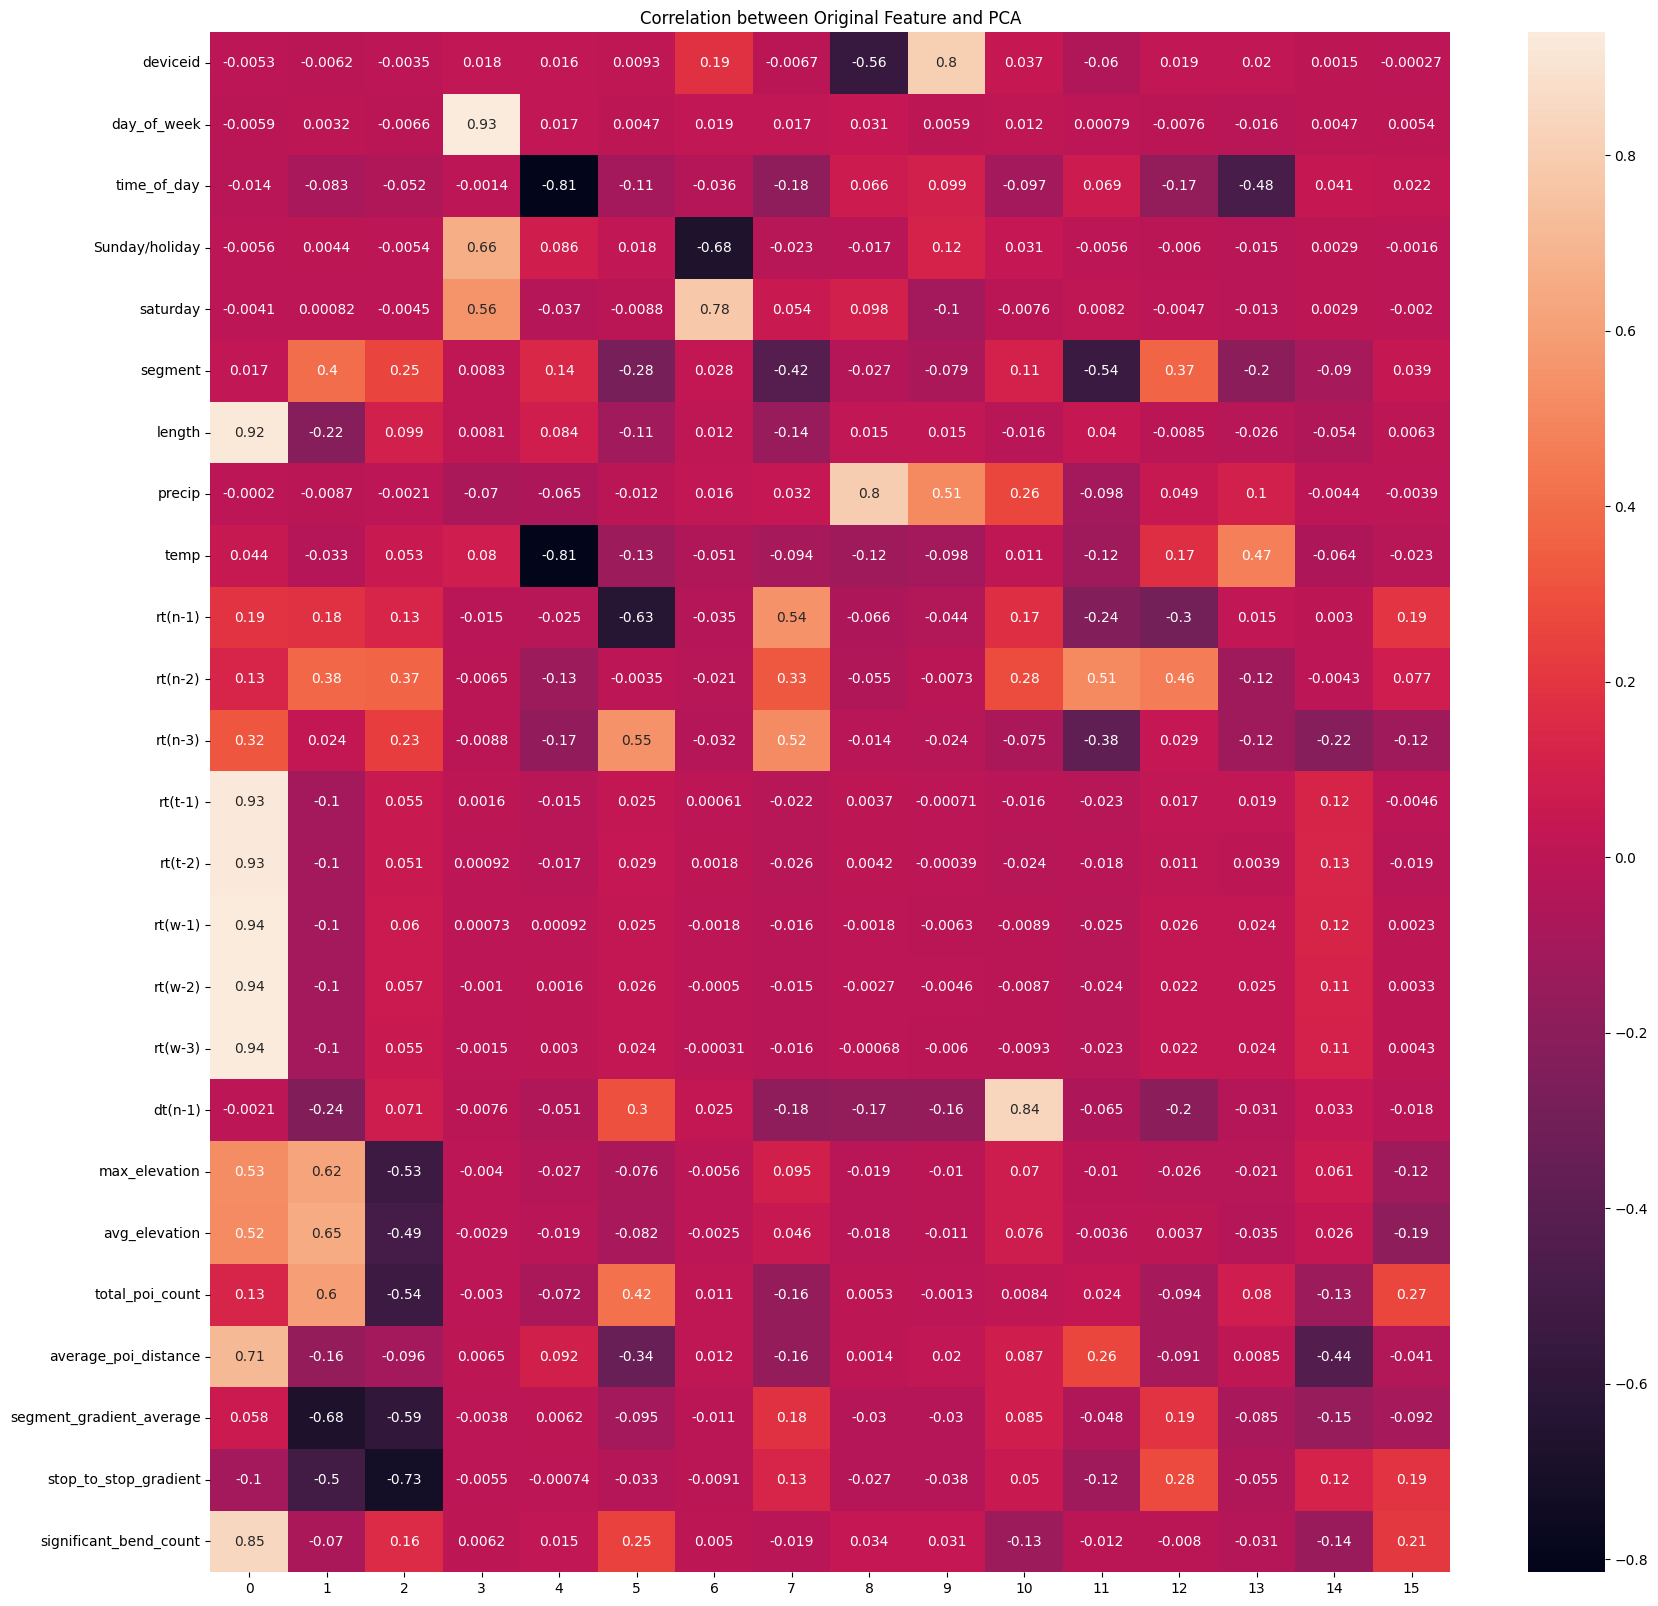

In [26]:
plt.figure(figsize=[20,20])
sns.heatmap(data=loading_matrix,annot=True)
plt.title('Correlation between Original Feature and PCA')

In [27]:
x_importance = X_test_pca
explainer = shap.TreeExplainer(run_time_model)
shap_values = explainer.shap_values(x_importance)

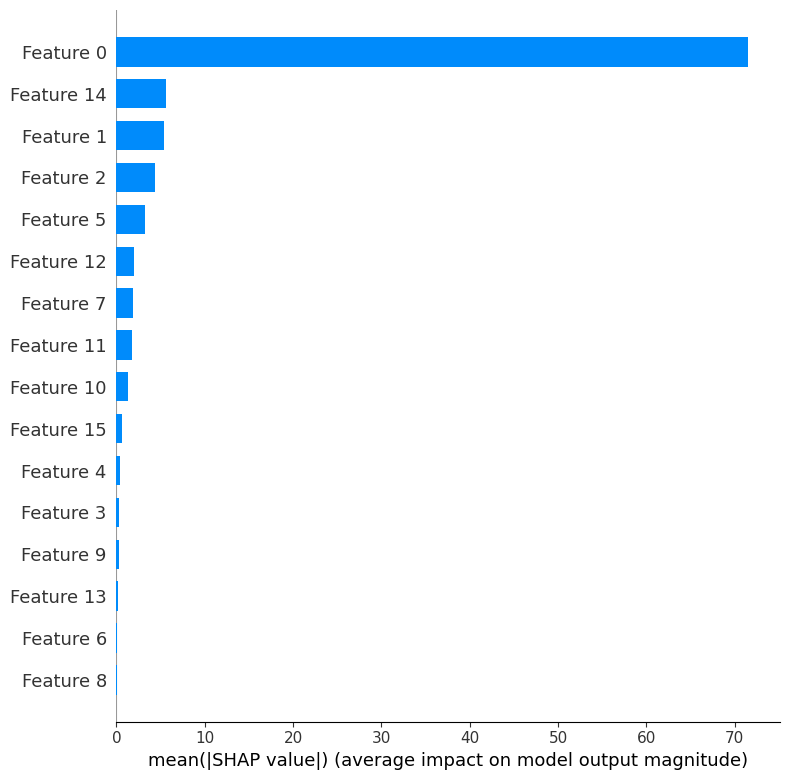

In [28]:
shap.summary_plot(shap_values,x_importance,plot_type="bar")